In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import glob

In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\

In [2]:
# define the years 
Year = list(range(2001,2009)) + list(range(2013,2019))

##### Read Climate and NDVI data

In [3]:
# read Climate csv

climate_csv = glob.glob('./Data/without_cloud_mask/Climate_*.csv')
climate_df_list = []

for f in climate_csv:
       
    # reand the df and parse date
    df = pd.read_csv(f,parse_dates=['Date'])
    climate_df_list.append(df)

# concat all climate_df into one df
climate_df = pd.concat(climate_df_list,0)
climate_df.reset_index(inplace=True,drop=True)

In [4]:
# read NDVI_withou_cloud_mask csv

NDVI_csv = glob.glob('./Data/without_cloud_mask/MODIS_NDVI_*')
NDVI_df_list = []

for f in NDVI_csv:
       
    # reand the df and parse date
    df = pd.read_csv(f,parse_dates=['YMD'])
    # arrange the df
    df['Date'] = df['YMD']
    df = df.drop('YMD',1)
    df = df[['Date','NAME', 'NDVI' ]]
    
    NDVI_df_list.append(df)

# concat all climate_df into one df
NDVI_df = pd.concat(NDVI_df_list,0)
NDVI_df.reset_index(inplace=True,drop=True)

In [61]:
# read NDVI_cloud_masked csv

NDVI_masked_csv = glob.glob('./Data/with_cloud_mask/*.csv')
NDVI_masked_df_list = []

for f in NDVI_masked_csv:
       
    # reand the df and parse date
    df = pd.read_csv(f,parse_dates=['YMD'])
    # arrange the df
    df['Date'] = df['YMD']
    df = df.drop('YMD',1)
    df = df[['Date','NAME', 'NDVI' ]]
    df = df.interpolate(method='linear', limit_direction='both', axis=0)
    
    
    NDVI_masked_df_list.append(df)

# concat all climate_df into one df
NDVI_masked_df = pd.concat(NDVI_masked_df_list,0)
NDVI_masked_df.reset_index(inplace=True,drop=True)

##### Note that masked-NDVI is less affected by noisy than raw-NDVI, so we interpolate the maked-NDVI at each day of a given year

In [132]:
# get one county and plot the ndvi
df_one_masked_ndvi = NDVI_masked_df[(NDVI_masked_df['NAME'] == '博爱县')&(NDVI_masked_df['Date'].dt.year == 2008)]
df_one_raw_ndvi   = NDVI_df[(NDVI_masked_df['NAME'] == '博爱县')&(NDVI_masked_df['Date'].dt.year == 2008)]

<AxesSubplot:xlabel='Date', ylabel='NDVI'>

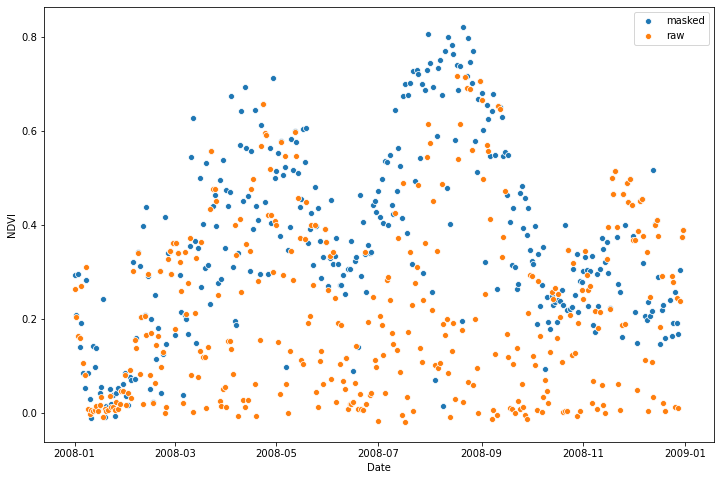

In [133]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=df_one_masked_ndvi,x='Date',y='NDVI',label='masked')
sns.scatterplot(data=df_one_raw_ndvi,  x='Date',y='NDVI',label='raw')

<AxesSubplot:>

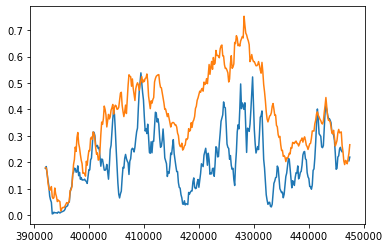

In [134]:
df_msk = (df_one_masked_ndvi['NDVI'].rolling(7).sum()/7)
df_raw = (df_one_raw_ndvi['NDVI'].rolling(7).sum()/7)

df_raw.plot()
df_msk.plot()

In [135]:
from symfit import parameters, variables, sin, cos, Fit

def fourier_series(x, f, n=0):
    """
    Returns a symbolic fourier series of order `n`.

    :param n: Order of the fourier series.
    :param x: Independent variable
    :param f: Frequency of the fourier series
    """
    # Make the parameter objects for all the terms
    a0, *cos_a = parameters(','.join(['a{}'.format(i) for i in range(0, n + 1)]))
    sin_b = parameters(','.join(['b{}'.format(i) for i in range(1, n + 1)]))
    # Construct the series
    series = a0 + sum(ai * cos(i * f * x) + bi * sin(i * f * x)
                     for i, (ai, bi) in enumerate(zip(cos_a, sin_b), start=1))
    return series

x, y = variables('x, y')
w, = parameters('w')
model_dict = {y: fourier_series(x, f=w, n=3)}
print(model_dict)

{y: a0 + a1*cos(w*x) + a2*cos(2*w*x) + a3*cos(3*w*x) + b1*sin(w*x) + b2*sin(2*w*x) + b3*sin(3*w*x)}


C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\symfit\core\objectives.py:349: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  pre_sum = jac_comp * ((y - f) / sigma**2)[np.newaxis, ...]



Parameter Value        Standard Deviation
a0        3.653770e-01 7.165797e-03
a1        -1.629467e-01 1.001071e-02
a2        -3.967543e-02 1.212378e-02
a3        3.387496e-02 2.120666e-02
b1        -3.187458e-02 1.287540e-02
b2        1.999511e-02 9.258087e-03
b3        -1.141908e-01 1.113277e-02
w         9.705936e-01 1.890833e-02
Status message         Desired error not necessarily achieved due to precision loss.
Number of iterations   28
Objective              <symfit.core.objectives.LeastSquares object at 0x000001A879E414E0>
Minimizer              <symfit.core.minimizers.BFGS object at 0x000001A879ED6F98>

Goodness of fit qualifiers:
chi_squared            5.703494150613537
objective_value        2.8517470753067684
r_squared              0.5828814915657652


C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\symfit\core\objectives.py:381: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  p1 = hess_comp * ((y - f) / sigma**2)[np.newaxis, np.newaxis, ...]


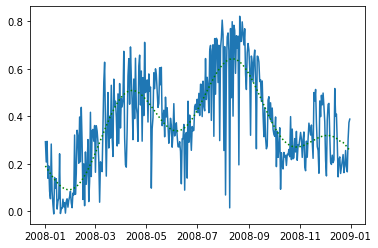

In [137]:
xdata = (np.arange(1,len(df_one_masked_ndvi) + 1))/len(df_one_masked_ndvi) * 2 * 3.1415
ydata = df_one_masked_ndvi['NDVI']

# Define a Fit object for this model and data
fit = Fit(model_dict, x=xdata, y=ydata)
fit_result = fit.execute()
print(fit_result)

# Plot the result
plt.plot(df_one_masked_ndvi['Date'], ydata)
plt.plot(df_one_masked_ndvi['Date'], fit.model(x=xdata, **fit_result.params).y, color='green', ls=':')